In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
import spacy
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from langdetect import detect

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alter\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alter\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# cargamos el archivo con reviews a un dataframe
df_rev = pd.read_parquet('CleanData/reviews.parquet')
df_rev.head()

,user_id,review,item_id,recommend,Año
0,76561197970982479,Simple yet with great replayability. In my opi...,1250,1,2011
1,76561197970982479,It's unique and worth a playthrough.,22200,1,2011
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,43110,1,2011
3,js41637,I know what you think when you see this title ...,251610,1,2014
4,js41637,For a simple (it's actually not all that simpl...,227300,1,2013


In [3]:
# Descargamos las stopwords de los tres idiomas principales detectados.

stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_sp = nltk.corpus.stopwords.words('spanish')
stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords = stopwords_en + stopwords_pt + stopwords_sp

# definimos una función para limpiar los textos de reviews

def clean_text(rev):
    if pd.isna(rev) or rev is None:
        return rev
    else:
        # limpieza
        rev = str(rev)
        rev = rev.lower()
        rev= rev.replace('\n', '')
        rev = unidecode(rev)
        rev = re.sub(r'https?://\S+|www\.\S+', '', rev)

        # tokenización
        rev = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(rev)

        # quitar stopwords
        rev = [word.strip() for word in rev if word not in stopwords]
        return rev

nlp_english = spacy.load('en_core_web_sm')          # cargamos nlp en inglés, español y portugués
nlp_spanish = spacy.load('es_core_news_sm')
nlp_portuguese = spacy.load('pt_core_news_sm')

# definimos una función para cambiar la función posicional de las palabras a una expresión de una sola letra
def get_wordnet_pos(pos):
    if pos == 'VERB':
        return 'v'
    elif pos == 'ADJ':
        return 'a'
    elif pos == 'ADV':
        return 'r'
    elif pos == 'NOUN':
        return 'n'
    else:
        return 'n'

# definimos una función para lemmatizar el texto de cada review
def lemmatize_text(rev):
    if rev is None:
        return rev

    lemmatizer = WordNetLemmatizer()

    # Obtener posiciones gramaticales en un conjunto
    pos_set = {'VERB', 'ADJ', 'ADV', 'NOUN'}

    # seleccionamos el nlp según el idioma que se detecta:
    try:
        lang = detect(' '.join(rev))
    except Exception as e:
        lang = 'en'  # Si hay un error, utiliza inglés como predeterminado  
    
    if lang == 'en':
        nlp = nlp_english
    elif lang == 'es':
        nlp = nlp_spanish
    elif lang == 'pt':
        nlp = nlp_portuguese
    else:
        # Si no se detecta un idioma específico, utiliza inglés como predeterminado
        nlp = nlp_english

    # Lematizar en lotes usando spaCy
    doc = nlp(' '.join(rev))

    lemmatized_words = [lemmatizer.lemmatize(token.text, get_wordnet_pos(token.pos_)) for token in doc if token.pos_ in pos_set]

    return lemmatized_words


In [4]:
df_rev['review_tokenized'] = df_rev['review'].apply(clean_text)
df_rev.head()

,user_id,review,item_id,recommend,Año,review_tokenized
0,76561197970982479,Simple yet with great replayability. In my opi...,1250,1,2011,"[simple, yet, great, replayability, opinion, z..."
1,76561197970982479,It's unique and worth a playthrough.,22200,1,2011,"[unique, worth, playthrough]"
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,43110,1,2011,"[great, atmosphere, gunplay, bit, chunky, time..."
3,js41637,I know what you think when you see this title ...,251610,1,2014,"[know, think, see, title, barbie, dreamhouse, ..."
4,js41637,For a simple (it's actually not all that simpl...,227300,1,2013,"[simple, actually, simple, truck, driving, sim..."


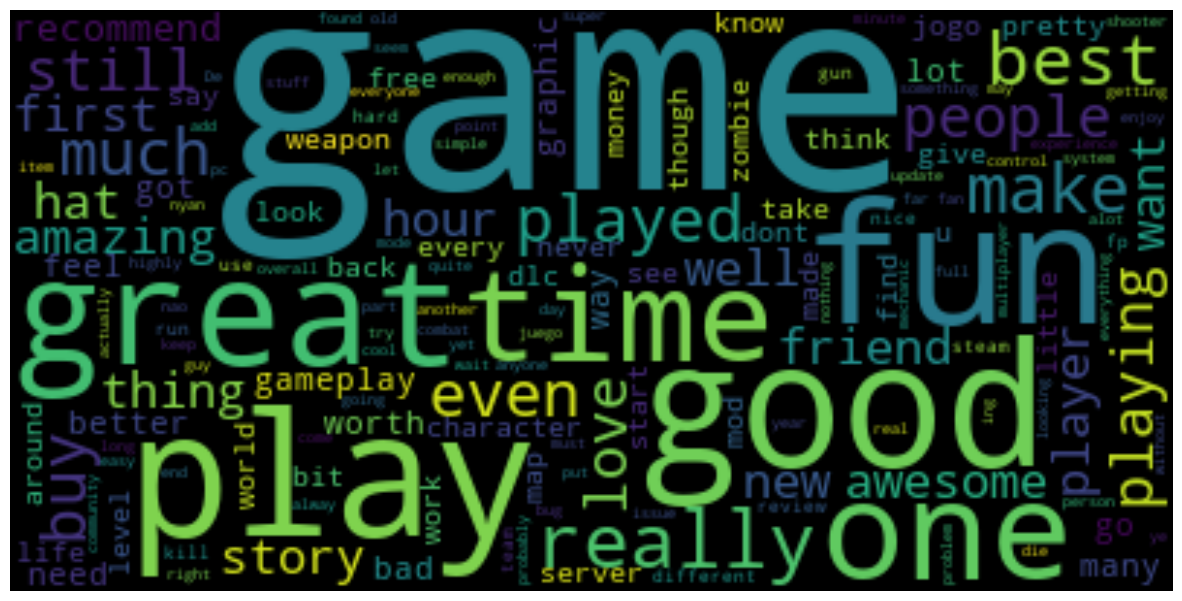

In [5]:
# generemos una nube de palabras
text = " ".join(i for i in df_rev['review_tokenized'].apply(lambda x: ' '.join(x) if x is not None else None) if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
tqdm.pandas()

In [7]:
# Aplicar la función a la columna
df_rev['review_lemmatized'] = df_rev['review_tokenized'].progress_apply(lemmatize_text)

100%|██████████| 58431/58431 [12:11<00:00, 79.91it/s] 


In [8]:
df_rev.head()

,user_id,review,item_id,recommend,Año,review_tokenized,review_lemmatized
0,76561197970982479,Simple yet with great replayability. In my opi...,1250,1,2011,"[simple, yet, great, replayability, opinion, z...","[simple, great, replayability, opinion, zombie..."
1,76561197970982479,It's unique and worth a playthrough.,22200,1,2011,"[unique, worth, playthrough]","[unique, worth, playthrough]"
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,43110,1,2011,"[great, atmosphere, gunplay, bit, chunky, time...","[great, atmosphere, gunplay, bit, chunky, time..."
3,js41637,I know what you think when you see this title ...,251610,1,2014,"[know, think, see, title, barbie, dreamhouse, ...","[know, think, see, title, intimidate, title, e..."
4,js41637,For a simple (it's actually not all that simpl...,227300,1,2013,"[simple, actually, simple, truck, driving, sim...","[simple, actually, simple, truck, drive, simul..."


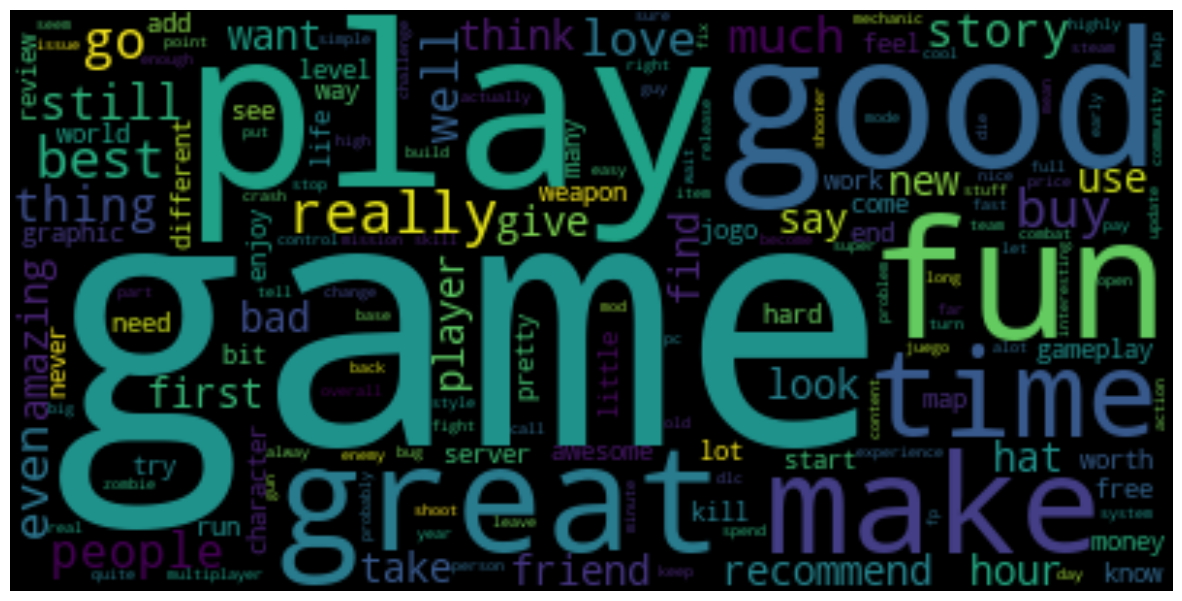

In [9]:
# generemos una nube de palabras
text = " ".join(i for i in df_rev['review_lemmatized'].apply(lambda x: ' '.join(x) if x is not None else None) if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
df_rev['rev_complete'] = df_rev['review_lemmatized'].progress_apply(lambda x: ' '.join(x) if x is not None else None)

100%|██████████| 58431/58431 [00:00<00:00, 657788.11it/s]


In [11]:
df_rev.head()

,user_id,review,item_id,recommend,Año,review_tokenized,review_lemmatized,rev_complete
0,76561197970982479,Simple yet with great replayability. In my opi...,1250,1,2011,"[simple, yet, great, replayability, opinion, z...","[simple, great, replayability, opinion, zombie...",simple great replayability opinion zombie hord...
1,76561197970982479,It's unique and worth a playthrough.,22200,1,2011,"[unique, worth, playthrough]","[unique, worth, playthrough]",unique worth playthrough
2,76561197970982479,Great atmosphere. The gunplay can be a bit chu...,43110,1,2011,"[great, atmosphere, gunplay, bit, chunky, time...","[great, atmosphere, gunplay, bit, chunky, time...",great atmosphere gunplay bit chunky time end d...
3,js41637,I know what you think when you see this title ...,251610,1,2014,"[know, think, see, title, barbie, dreamhouse, ...","[know, think, see, title, intimidate, title, e...",know think see title intimidate title easily g...
4,js41637,For a simple (it's actually not all that simpl...,227300,1,2013,"[simple, actually, simple, truck, driving, sim...","[simple, actually, simple, truck, drive, simul...",simple actually simple truck drive simulator q...


In [12]:
# nos quedamos solamente con las columnas que vamos a utilizar más tarde.
df_rev_final = df_rev[['user_id', 'item_id', 'rev_complete', 'recommend', 'Año']]
df_rev_final.head()

,user_id,item_id,rev_complete,recommend,Año
0,76561197970982479,1250,simple great replayability opinion zombie hord...,1,2011
1,76561197970982479,22200,unique worth playthrough,1,2011
2,76561197970982479,43110,great atmosphere gunplay bit chunky time end d...,1,2011
3,js41637,251610,know think see title intimidate title easily g...,1,2014
4,js41637,227300,simple actually simple truck drive simulator q...,1,2013


In [13]:
# agregamos la columna sentiment_analysis. En una primera aproximación, utilizamos SentimentIntensityAnalizer de nltk
analyzer = SentimentIntensityAnalyzer()
df_rev_final['sentiment_analysis'] = df_rev_final['rev_complete'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'] if x is not None else 0)

  0%|          | 0/58431 [00:00<?, ?it/s]

100%|██████████| 58431/58431 [00:09<00:00, 6403.25it/s]


In [14]:
# dado que se solicita que la escala sea: '0' si es malo, '1' si es neutral y '2' si es positivo, aplicamos el cambio a la columna:
df_rev_final['sentiment_analysis'] = df_rev_final['sentiment_analysis'] + 1

In [15]:
df_rev_final.head()

,user_id,item_id,rev_complete,recommend,Año,sentiment_analysis
0,76561197970982479,1250,simple great replayability opinion zombie hord...,1,2011,1.8020
1,76561197970982479,22200,unique worth playthrough,1,2011,1.2263
2,76561197970982479,43110,great atmosphere gunplay bit chunky time end d...,1,2011,1.8910
3,js41637,251610,know think see title intimidate title easily g...,1,2014,1.7717
4,js41637,227300,simple actually simple truck drive simulator q...,1,2013,1.9514


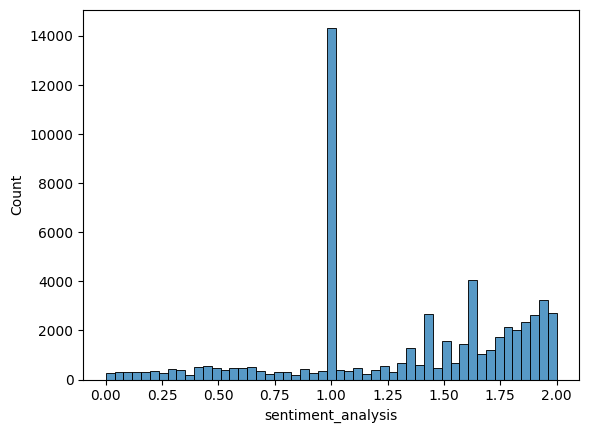

In [16]:
sns.histplot(df_rev_final['sentiment_analysis']);

In [17]:
# podemos observar que la mayor parte de los comentarios tienen sentimiento 'neutro', 
# y además que hay más comentarios positivos que negativos.
# veamos cuantos comentarios vacios imputamos en neutro:
df_rev.replace(['',' ', ['']], np.nan).isna().sum()

user_id                 0
review                 38
item_id                 0
recommend               0
Año                     0
review_tokenized       38
review_lemmatized      38
rev_complete         2962
dtype: int64

In [18]:
df_rev[df_rev_final['rev_complete'].isin(['',' ', [''], [], np.nan])]

,user_id,review,item_id,recommend,Año,review_tokenized,review_lemmatized,rev_complete
68,76561198070565427,"w,",570,0,2014,[w],[],
69,76561198070565427,ก็สนุกเเต่เจ่าของเกมครับชวยเอาไอพวกที่ชอบด่าได...,224260,1,2014,"[ksnukeetecchaakh, ngekmkhrabchwye, aaai, phwk...",[],
83,boydeer,สนุกมากเลยคับ,440,1,2014,[snukmaakelykhab],[],
97,diego9031,Jogo ♥♥♥♥.,1250,1,2015,[jogo],[],
99,diego9031,Thisgame is so cool,204360,1,2015,"[thisgame, cool]",[],
...,...,...,...,...,...,...,...,...
58356,76561198227671916,要是主线任务能长一点就更好了= =,211820,1,2014,"[Yao, Shi, Zhu, Xian, Ren, Wu, Neng, Chang, Yi...",[],
58366,Assult_Satan,yes,730,1,2015,[yes],[],
58374,AusBacon,♥♥♥♥,369290,0,2014,[],[],
58399,3214213216,잼꾸르잼,240,1,2014,[jaemggureujaem],[],


In [19]:
df_rev[df_rev_final['rev_complete'].isin(['',' ', ['']])]['review'].apply(clean_text).apply(lemmatize_text)

68       []
69       []
83       []
97       []
99       []
         ..
58356    []
58366    []
58374    []
58399    []
58429    []
Name: review, Length: 2924, dtype: object

In [20]:
# Reemplazamos 2964 datos que fueron imputados como neutros. 
# al parecer puede ser un mejor sistema asignar 2 en la columna sentiment analysis cuando recommend es 1, y 1 cuando recommend es 0.



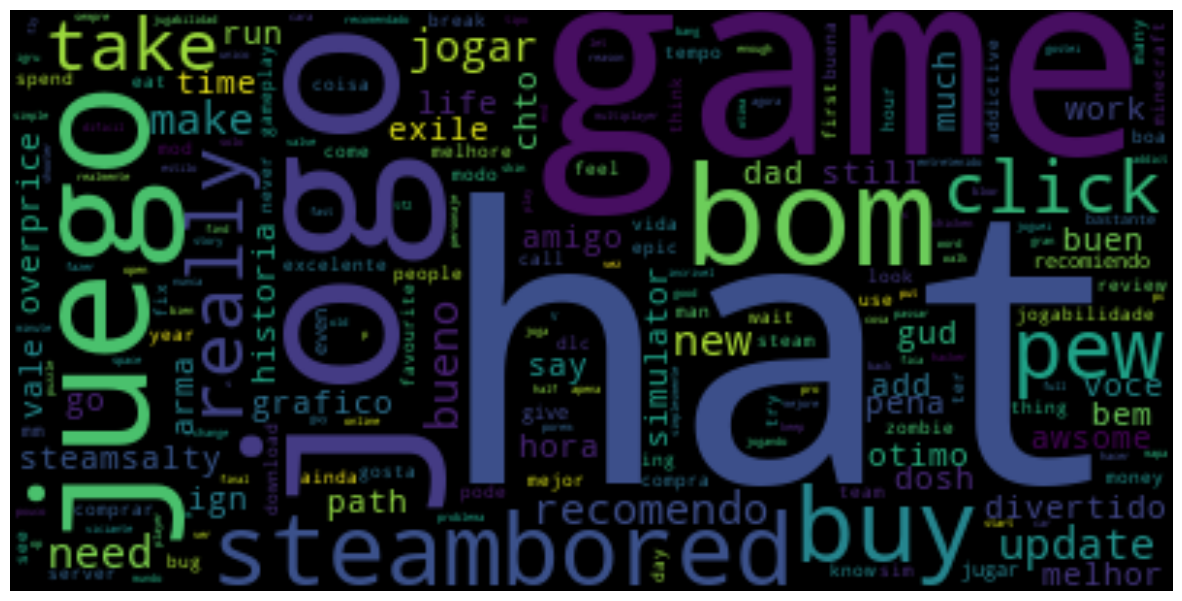

In [21]:
df_neutros = df_rev_final[df_rev_final['sentiment_analysis'] == 1]
text = " ".join(i for i in df_neutros['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

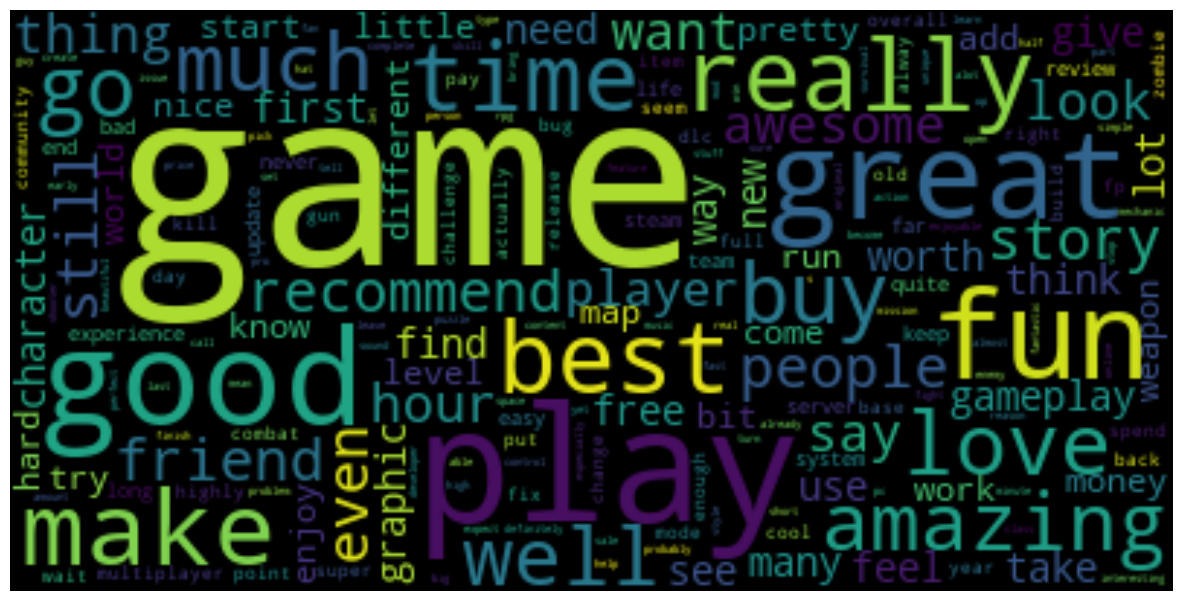

In [22]:
df_positivos = df_rev_final[df_rev_final['sentiment_analysis'] > 1]
text = " ".join(i for i in df_positivos['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

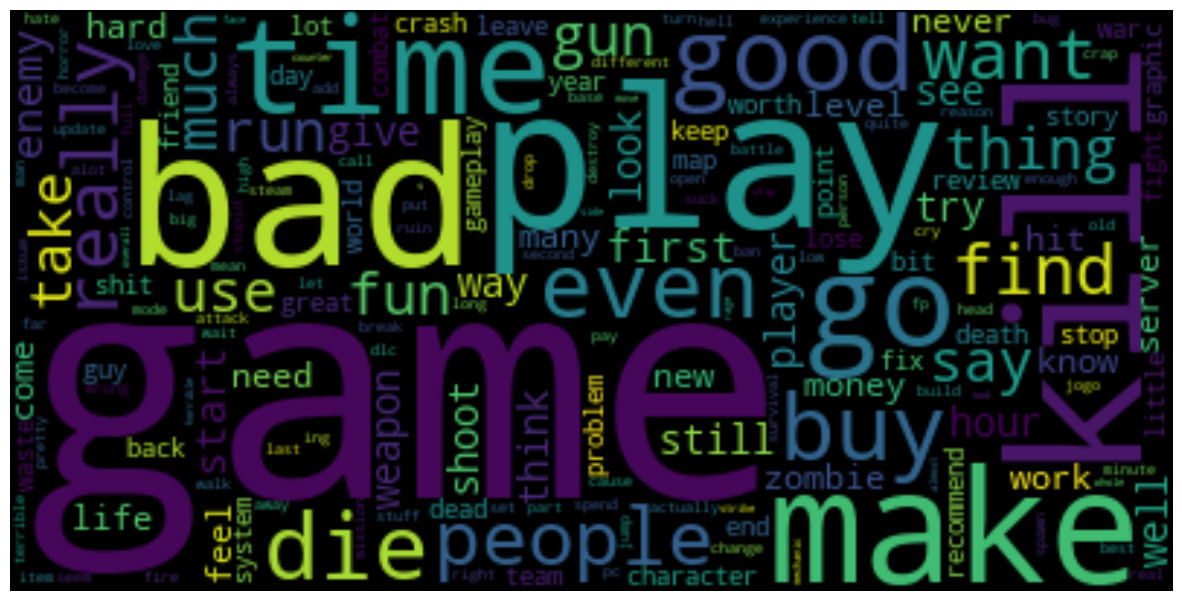

In [23]:
df_negativos = df_rev_final[df_rev_final['sentiment_analysis'] < 1]
text = " ".join(i for i in df_negativos['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
df_rev_final.head()

,user_id,item_id,rev_complete,recommend,Año,sentiment_analysis
0,76561197970982479,1250,simple great replayability opinion zombie hord...,1,2011,1.8020
1,76561197970982479,22200,unique worth playthrough,1,2011,1.2263
2,76561197970982479,43110,great atmosphere gunplay bit chunky time end d...,1,2011,1.8910
3,js41637,251610,know think see title intimidate title easily g...,1,2014,1.7717
4,js41637,227300,simple actually simple truck drive simulator q...,1,2013,1.9514


In [25]:
df_to_parquet = df_rev_final[['user_id', 'item_id', 'sentiment_analysis', 'Año']]
df_to_parquet['sentiment_analysis'] = np.where(df_to_parquet['sentiment_analysis'] < 1 , 0,
                                              np.where(df_to_parquet['sentiment_analysis'] > 1, 2,
                                               1 ))
df_to_parquet.head()

,user_id,item_id,sentiment_analysis,Año
0,76561197970982479,1250,2,2011
1,76561197970982479,22200,2,2011
2,76561197970982479,43110,2,2011
3,js41637,251610,2,2014
4,js41637,227300,2,2013


<Axes: xlabel='sentiment_analysis', ylabel='Count'>

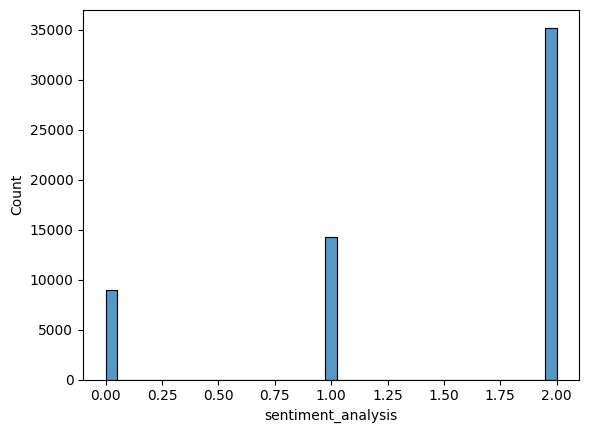

In [26]:
sns.histplot(df_to_parquet['sentiment_analysis'])

In [27]:
# df_to_parquet.to_parquet('sentiment_analysis.parquet')

In [28]:
df_rev_final.head()

,user_id,item_id,rev_complete,recommend,Año,sentiment_analysis
0,76561197970982479,1250,simple great replayability opinion zombie hord...,1,2011,1.8020
1,76561197970982479,22200,unique worth playthrough,1,2011,1.2263
2,76561197970982479,43110,great atmosphere gunplay bit chunky time end d...,1,2011,1.8910
3,js41637,251610,know think see title intimidate title easily g...,1,2014,1.7717
4,js41637,227300,simple actually simple truck drive simulator q...,1,2013,1.9514


In [29]:
## en esta celda, lo que hacemos es generar una nueva columna de analisis de sentimiento, en la cual los reviews que quedaron vacios luego de la
## lemmatización, son asignados como sentimiento 1 si el usuario recomendó el item, y como 0 si el usuario no lo recomendó
vacios = ['', ' ', [], [''], [' '], None]
df_rev_final['sentiment_analysis_2'] = df_rev_final['rev_complete'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'] if x not in vacios else 
                                                                                   (1 if df_rev_final.loc[df_rev_final['rev_complete'] == x, 'recommend'].any() == 1 else 0))

100%|██████████| 58431/58431 [00:21<00:00, 2679.83it/s]


In [30]:
df_rev_final.head()

,user_id,item_id,rev_complete,recommend,Año,sentiment_analysis,sentiment_analysis_2
0,76561197970982479,1250,simple great replayability opinion zombie hord...,1,2011,1.8020,0.8020
1,76561197970982479,22200,unique worth playthrough,1,2011,1.2263,0.2263
2,76561197970982479,43110,great atmosphere gunplay bit chunky time end d...,1,2011,1.8910,0.8910
3,js41637,251610,know think see title intimidate title easily g...,1,2014,1.7717,0.7717
4,js41637,227300,simple actually simple truck drive simulator q...,1,2013,1.9514,0.9514


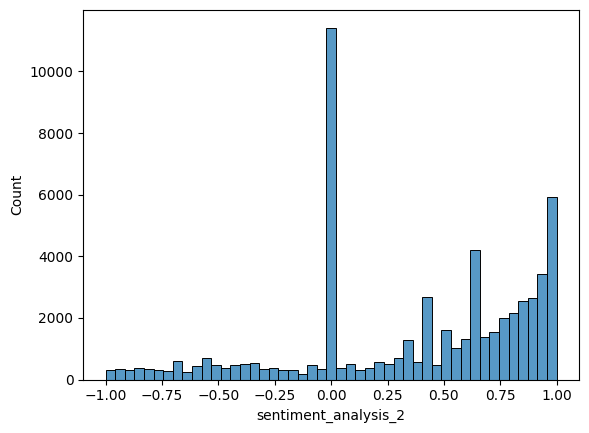

In [31]:
sns.histplot(df_rev_final['sentiment_analysis_2']);

In [32]:
# sumamos 1 al análisis de sentimiento para concordar con los valores pedidos
df_rev_final['sentiment_analysis_2'] = df_rev_final['sentiment_analysis_2'] +1

In [33]:
# hacemos un nuevo dataframe con los datos de este nuevo análisis de sentimiento
df_to_parquet_2 = df_rev_final[['user_id', 'item_id', 'sentiment_analysis_2', 'recommend', 'Año']]
df_to_parquet_2['sentiment_analysis_2'] = np.where(df_to_parquet_2['sentiment_analysis_2'] < 1 , 0,
                                              np.where(df_to_parquet_2['sentiment_analysis_2'] > 1, 2,
                                               1 ))
df_to_parquet_2.head()

,user_id,item_id,sentiment_analysis_2,recommend,Año
0,76561197970982479,1250,2,1,2011
1,76561197970982479,22200,2,1,2011
2,76561197970982479,43110,2,1,2011
3,js41637,251610,2,1,2014
4,js41637,227300,2,1,2013


<Axes: xlabel='sentiment_analysis_2', ylabel='Count'>

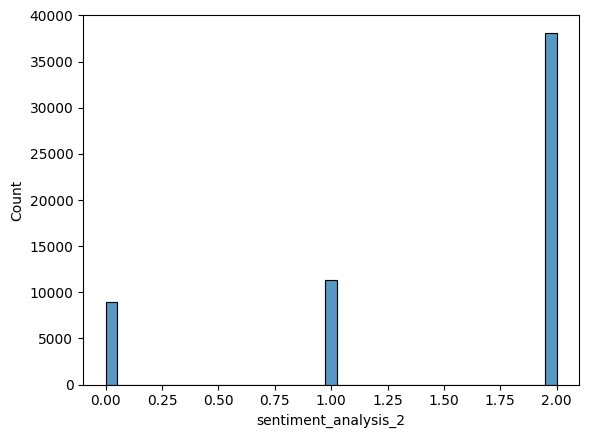

In [34]:
sns.histplot(df_to_parquet_2['sentiment_analysis_2'])

In [35]:
df_to_parquet_2['sentiment_analysis_2'].value_counts()

sentiment_analysis_2
2    38136
1    11368
0     8927
Name: count, dtype: int64

In [36]:
df_to_parquet_2.head()

,user_id,item_id,sentiment_analysis_2,recommend,Año
0,76561197970982479,1250,2,1,2011
1,76561197970982479,22200,2,1,2011
2,76561197970982479,43110,2,1,2011
3,js41637,251610,2,1,2014
4,js41637,227300,2,1,2013


In [37]:
df_to_parquet_2.to_parquet('sentiment_analysis_2.parquet')